<a href="https://colab.research.google.com/github/SoYeoni621/mulcam/blob/master/0304_Fri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((-1, 28, 28, 1))
test_images = test_images.reshape((-1, 28, 28, 1))

# normalization
train_images = train_images/255.
test_images = test_images/255.

valid_images, test_images, valid_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.15, shuffle=True)

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

class ConvBNRelu(Model):
    def __init__(self, filters, kernel_size=3, strides=(1,1), padding='same'):
        super(ConvBNRelu, self).__init__()
        self.conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides,
                           padding=padding, kernel_initializer='glorot_normal')
        
        self.batchnorm = BatchNormalization()

    def call(self, inputs, training=False):
        layer = self.conv(inputs)
        layer = self.batchnorm(layer)
        layer = tf.nn.relu(layer)

        return layer
        

In [3]:
# Dense에 Batchnorm 적용
class DenseBNRelu(Model):
    def __init__(self, units):
        super(DenseBNRelu, self).__init__()
        self.dense = Dense(units=units, kernel_initializer='glorot_normal')
        self.batchnorm = BatchNormalization()

    def call(self, inputs, training=False):
        layer = self.dense(inputs)
        layer = self.batchnorm(layer)
        layer = tf.nn.relu(layer)

        return layer


In [4]:
class MNISTModel(Model):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = ConvBNRelu(filters=32, kernel_size=(3, 3), padding='valid')
        self.pool1 = MaxPool2D()
        self.conv2 = ConvBNRelu(filters=64, kernel_size=(3, 3), padding='valid')
        self.pool2 = MaxPool2D()
        self.conv3 = ConvBNRelu(filters=64, kernel_size=(3, 3), padding='valid')
        self.flat = Flatten()
        self.dense4 = DenseBNRelu(units=64)
        self.drop = Dropout(0.2)
        self.outputs = Dense(10, activation='softmax')

    def call(self, inputs, training=False):
        net = self.conv1(inputs)
        net = self.pool1(net)
        net = self.conv2(net)
        net = self.pool2(net)
        net = self.conv3(net)
        net = self.flat(net)
        net = self.dense4(net)
        net = self.drop(net)
        net = self.outputs(net)

        return net

In [5]:
model = MNISTModel()
model(Input(shape=(28, 28, 1)))
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_bn_relu (ConvBNRelu)   multiple                  448       
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv_bn_relu_1 (ConvBNRelu)  multiple                 18752     
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv_bn_relu_2 (ConvBNRelu)  multiple                 37184     
                                                                 
 flatten (Flatten)           multiple                  

In [6]:
!rm '/content/drive/MyDrive/딥러닝 NLP/models'*

rm: cannot remove '/content/drive/MyDrive/딥러닝 NLP/models': Is a directory


In [3]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

MODEL_SAVE_FOLDER = '/content/drive/MyDrive/딥러닝 NLP/models/'
model_path = f"{MODEL_SAVE_FOLDER}mmist-{{epoch:d}}-{{val_loss:.5f}}-{{val_accuracy:.5f}}.hdf5"

cb_checkpoint = ModelCheckpoint(filepath=model_path, 
                                monitor='val_accuracy',
                                save_weights_only=True,
                                verbose=1,
                                save_best_only=True)
cb_early_stopping= EarlyStopping(monitor='val_accuracy',patience=6) # did not imporoved가 연속으로 6번 나오면 학습 stop

In [8]:
learning_rate = 0.001
batch_size = 200

lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate, train_images.shape[0]/batch_size*5, 0.5, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_decay)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
hist = model.fit(train_images, train_labels, validation_data=(valid_images, valid_labels),
                 epochs=100, batch_size=batch_size, 
                 callbacks=[cb_checkpoint, cb_early_stopping])

Epoch 1/100
300/300 [==============================] - ETA: 0s - loss: 0.2082 - accuracy: 0.9510
Epoch 1: val_accuracy improved from -inf to 0.11294, saving model to /content/drive/MyDrive/딥러닝 NLP/models/mmist-1-4.40705-0.11294.hdf5
300/300 [==============================] - 13s 26ms/step - loss: 0.2082 - accuracy: 0.9510 - val_loss: 4.4071 - val_accuracy: 0.1129
Epoch 2/100
298/300 [============================>.] - ETA: 0s - loss: 0.0525 - accuracy: 0.9864
Epoch 2: val_accuracy improved from 0.11294 to 0.98282, saving model to /content/drive/MyDrive/딥러닝 NLP/models/mmist-2-0.05850-0.98282.hdf5
300/300 [==============================] - 6s 20ms/step - loss: 0.0523 - accuracy: 0.9864 - val_loss: 0.0585 - val_accuracy: 0.9828
Epoch 3/100
298/300 [============================>.] - ETA: 0s - loss: 0.0356 - accuracy: 0.9898
Epoch 3: val_accuracy did not improve from 0.98282
300/300 [==============================] - 6s 19ms/step - loss: 0.0356 - accuracy: 0.9899 - val_loss: 0.0649

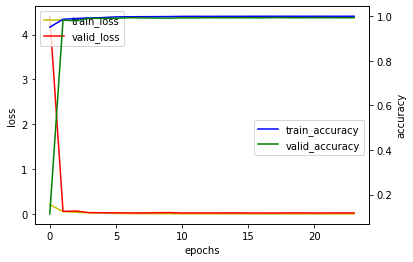

In [10]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='valid_loss')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['accuracy'], 'b', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='valid_accuracy')
acc_ax.set_xlabel('epochs')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right', bbox_to_anchor=(1, 0.5))

plt.show()

# VGG16 실습(사전 학습 모델pre-trained model)

In [1]:
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(train_images.shape, test_images.shape)

(60000, 28, 28) (10000, 28, 28)


In [3]:
# 3 채널로 만들기 위한 작업
train_images = train_images.reshape(-1, 784)
test_images = test_images.reshape(-1, 784)

print(train_images.shape, test_images.shape)

(60000, 784) (10000, 784)


In [5]:
# 3 채널로 만들기
train_images = np.dstack([train_images]*3)
test_images = np.dstack([test_images]*3)

In [6]:
train_images.shape, test_images.shape

((60000, 784, 3), (10000, 784, 3))

In [7]:
# 이미지 형식으로 변경
train_images = train_images.reshape(-1, 28, 28, 3)
test_images = test_images.reshape(-1, 28, 28, 3)


In [8]:
train_images.shape, test_images.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [9]:
train_images[0][0]

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=uint8)

In [10]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

#48*48 사이즈로 변경

train_images = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48, 48))) for im in train_images])
test_images = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48, 48))) for im in test_images])

In [11]:
train_images.shape,  test_images.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [12]:
train_images = train_images/ 255.
test_images = test_images / 255.


In [13]:
valid_images, test_images, valid_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.15, shuffle=True)

In [14]:
# 사전 학습된 VGG모델 가져오기
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [15]:
# 모델 레이어 데이터화
layer_dict = {layer.name : layer for layer in vgg_model.layers}
layer_dict

{'block1_conv1': <keras.layers.convolutional.Conv2D at 0x7ff43c02f990>,
 'block1_conv2': <keras.layers.convolutional.Conv2D at 0x7ff43ffb5f50>,
 'block1_pool': <keras.layers.pooling.MaxPooling2D at 0x7ff43bf6ee50>,
 'block2_conv1': <keras.layers.convolutional.Conv2D at 0x7ff43bf8b250>,
 'block2_conv2': <keras.layers.convolutional.Conv2D at 0x7ff43bf1aed0>,
 'block2_pool': <keras.layers.pooling.MaxPooling2D at 0x7ff43bfc1150>,
 'block3_conv1': <keras.layers.convolutional.Conv2D at 0x7ff43bf20390>,
 'block3_conv2': <keras.layers.convolutional.Conv2D at 0x7ff43bf27150>,
 'block3_conv3': <keras.layers.convolutional.Conv2D at 0x7ff43bf30310>,
 'block3_pool': <keras.layers.pooling.MaxPooling2D at 0x7ff43bf30ed0>,
 'block4_conv1': <keras.layers.convolutional.Conv2D at 0x7ff43bf27550>,
 'block4_conv2': <keras.layers.convolutional.Conv2D at 0x7ff43bf37c50>,
 'block4_conv3': <keras.layers.convolutional.Conv2D at 0x7ff43bf42150>,
 'block4_pool': <keras.layers.pooling.MaxPooling2D at 0x7ff43c021b9

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

x = layer_dict['block2_conv2'].output

x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPool2D()(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(10, activation='softmax')(x)


In [26]:
# 새로운 모델 정의
custom_model = Model(inputs=vgg_model.input, outputs=x)
custom_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        7379

In [27]:
for layer in custom_model.layers[:7]:
	layer.trainable = False # pre-trained weight를 그대로 사용

custom_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

MODEL_SAVE_FOLDER = '/content/drive/MyDrive/딥러닝 NLP/models/'
model_path = f"{MODEL_SAVE_FOLDER}mmist-vgg-{{epoch:d}}-{{val_loss:.5f}}-{{val_accuracy:.5f}}.hdf5"

cb_checkpoint = ModelCheckpoint(filepath=model_path, 
                                monitor='val_accuracy',
                                save_weights_only=True,
                                verbose=1,
                                save_best_only=True)

cb_early_stopping= EarlyStopping(monitor='val_accuracy',patience=6) # did not imporoved가 연속으로 6번 나오면 학습 stop

In [30]:
hist = custom_model.fit(train_images, train_labels, validation_data=(valid_images, valid_labels),
                        epochs=100, batch_size=200,
                        callbacks=[cb_checkpoint, cb_early_stopping])

Epoch 1/100
300/300 [==============================] - ETA: 0s - loss: 1.3155 - accuracy: 0.8706
Epoch 1: val_accuracy improved from -inf to 0.97141, saving model to /content/drive/MyDrive/딥러닝 NLP/models/mmist-vgg-1-0.10049-0.97141.hdf5
300/300 [==============================] - 23s 68ms/step - loss: 1.3155 - accuracy: 0.8706 - val_loss: 0.1005 - val_accuracy: 0.9714
Epoch 2/100
300/300 [==============================] - ETA: 0s - loss: 0.1813 - accuracy: 0.9448
Epoch 2: val_accuracy improved from 0.97141 to 0.97706, saving model to /content/drive/MyDrive/딥러닝 NLP/models/mmist-vgg-2-0.07620-0.97706.hdf5
300/300 [==============================] - 20s 66ms/step - loss: 0.1813 - accuracy: 0.9448 - val_loss: 0.0762 - val_accuracy: 0.9771
Epoch 3/100
300/300 [==============================] - ETA: 0s - loss: 0.1675 - accuracy: 0.9494
Epoch 3: val_accuracy improved from 0.97706 to 0.97800, saving model to /content/drive/MyDrive/딥러닝 NLP/models/mmist-vgg-3-0.07279-0.97800.hdf5
30

In [31]:
!ls -la '/content/drive/MyDrive/딥러닝 NLP/models/'

total 211738
-rw------- 1 root root  404552 Mar  3 02:36 mmist-1-0.06941-0.97847.hdf5
-rw------- 1 root root  404552 Mar  3 02:36 mmist-11-0.02098-0.99376.hdf5
-rw------- 1 root root  419440 Mar  4 04:58 mmist-1-2.95404-0.21000.hdf5
-rw------- 1 root root  419440 Mar  4 06:04 mmist-13-0.02251-0.99341.hdf5
-rw------- 1 root root  419440 Mar  4 06:03 mmist-1-4.40705-0.11294.hdf5
-rw------- 1 root root  419664 Mar  4 05:33 mmist-1-5.05078-0.11235.hdf5
-rw------- 1 root root  404552 Mar  3 02:37 mmist-16-0.02293-0.99412.hdf5
-rw------- 1 root root  419440 Mar  4 06:05 mmist-18-0.02067-0.99376.hdf5
-rw------- 1 root root  404552 Mar  3 02:37 mmist-20-0.02262-0.99424.hdf5
-rw------- 1 root root  404552 Mar  3 02:36 mmist-2-0.04657-0.98506.hdf5
-rw------- 1 root root  419440 Mar  4 06:03 mmist-2-0.05850-0.98282.hdf5
-rw------- 1 root root  419664 Mar  4 05:33 mmist-2-0.07485-0.97718.hdf5
-rw------- 1 root root  419440 Mar  4 04:58 mmist-2-0.12078-0.96376.hdf5
-rw------- 1 root root  404552 Ma

In [32]:
saved_path = "/content/drive/MyDrive/딥러닝 NLP/models/mmist-vgg-15-0.04046-0.98800.hdf5"
custom_model.load_weights(saved_path)

custom_model.evaluate(test_images, test_labels)

47/47 [==============================] - 1s 17ms/step - loss: 0.0499 - accuracy: 0.9880


[0.049854181706905365, 0.9879999756813049]